<a href="https://colab.research.google.com/github/junelsolis/AAU-Machine-Learning/blob/main/Mini_Project_2_later.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initial setup and data import

In [2]:
!pip install tweet-preprocessor nltk keras-tuner
!pip install tqdm>=4.9.0

     |████████████████████████████████| 71kB 5.7MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.2-cp36-none-any.whl size=78939 sha256=0648e1258e69c968eb91b2d3ba7464ed3eea703c73b57f9fa500d61a183e1e7c
  Stored in directory: /root/.cache/pip/wheels/bb/a1/8a/7c3de0efb3707a1701b36ebbfdbc4e67aedf6d4943a1f463d6
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15358 sha256=4a15f06b8ecc00834d1b4c1696653432a375bad5e7d7bcb4dd87c2d86b032513
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [3]:
# Mount Drive folder
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# Make default library imports
import pandas as pd
import numpy as np
import preprocessor as p
import re
import matplotlib.pyplot as plt
from tqdm import tqdm

plt.style.use('fivethirtyeight')

%matplotlib inline

In [5]:
# Read the data from file
data = pd.read_csv('/content/drive/MyDrive/AAU-Machine-Learning/Mini-Project-2/Sentiment140.tenPercent.sample.tweets.tsv', delimiter='\t')
data.head()


,sentiment_label,tweet_text
0,4,"@elephantbird Hey dear, Happy Friday to You A..."
1,4,Ughhh layin downnnn Waiting for zeina to co...
2,0,"@greeniebach I reckon he'll play, even if he's..."
3,0,@vaLewee I know! Saw it on the news!
4,0,very sad that http://www.fabchannel.com/ has c...


Null values present in labels: False
Null values present in tweet text: False



<BarContainer object of 2 artists>

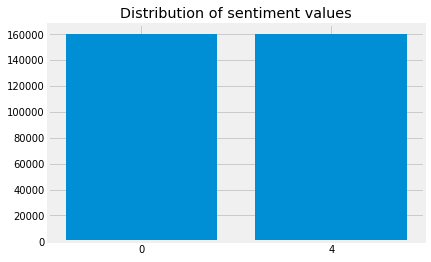

In [6]:
# Check for null values in the data
# Plot label histogram
print('Null values present in labels: ' + str(data['sentiment_label'].isnull().values.any()))
print('Null values present in tweet text: ' + str(data['tweet_text'].isnull().values.any()))
print()

plt.title('Distribution of sentiment values')
plt.bar(['0','4'], [len(data['sentiment_label'].where(data['sentiment_label'] == 0)), len(data['sentiment_label'].where(data['sentiment_label'] == 4))])


# Preprocess tweets

In [7]:
# Import NLTK dependencies
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop_words = set(stopwords.words('english'))

# Spacy dependencies
# import spacy
# nlp = spacy.load('en', disable=['parser', 'ner'])

import random

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [8]:
!pip install textblob
from textblob import TextBlob, Word

### Text processing functions

In [9]:
def process_tweet(tweet):

  clean_tweet = p.clean(tweet)
  # Remove punctuations and numbers
  clean_tweet = re.sub('[^a-zA-Z]', ' ', clean_tweet)

  # Convert to lower case
  clean_tweet = clean_tweet.lower()

  # Single character removal
  clean_tweet = re.sub(r"\s+[a-zA-Z]\s+", ' ', clean_tweet)

  # Removing multiple spaces
  clean_tweet = re.sub(r'\s+', ' ', clean_tweet)

  # Remove words longer
  clean_tweet_words = clean_tweet.split(' ')
  filter_max_word_length_tweet = []
  for w in clean_tweet_words:
    if (len(w) <= 40):
      filter_max_word_length_tweet.append(w)

  clean_tweet =  " ".join(filter_max_word_length_tweet)

  # Remove multiple spaces again
  clean_tweet = re.sub(r'\s+', ' ', clean_tweet)
  return clean_tweet


tag_dict = {"J": 'a', 
            "N": 'n', 
            "V": 'v', 
            "R": 'r'}

def lemmatize(tweet):
  blob = TextBlob(tweet)

  
  words_and_tags = [(Word(w), tag_dict.get(pos[0], 'n')) for w, pos in blob.tags]
  lemmatized_list = [wd.lemmatize(tag) for wd, tag in words_and_tags]

  return " ".join(lemmatized_list)


def remove_stop_words(tweet):

  word_tokens = word_tokenize(tweet)  
  
  filtered_sentence = []  
    
  for w in word_tokens:  
      if w not in stop_words:  
          filtered_sentence.append(w)  

  return " ".join(filtered_sentence)


def empty_single_word_tweets(tweet):
    if (len(tweet.split(' ')) > 1):
        return tweet
    else:
        return ''



In [10]:
# Clean the tweets. 
# Remove the following:
# - URLS
# - Hashtags
# - Mentions
# - Reserved words (RT, FAV)
# - Emojis
# - Smileys
# - Numbers

tqdm.pandas()

# Copy the dataset and retain the original data
clean_data = data.copy()
clean_data = clean_data.sample(70000) # reduce number of samples

# Convert labels to binary
clean_data.loc[clean_data['sentiment_label'] == 4, 'sentiment_label'] = 1


index = random.randrange(0, len(clean_data.index) - 1)

# Run tweet preprocessor for cleaning
clean_data['tweet_text'] = clean_data['tweet_text'].progress_apply(lambda row: process_tweet(row))

# Lemmatize
clean_data['tweet_text'] = clean_data['tweet_text'].progress_apply(lambda row: lemmatize(row))

# Remove stop words
clean_data['tweet_text'] = clean_data['tweet_text'].progress_apply(lambda row: remove_stop_words(row))

# Remove tweets with only a single word
clean_data['tweet_text'] = clean_data['tweet_text'].progress_apply(lambda row: empty_single_word_tweets(row))
clean_data.drop(clean_data[clean_data['tweet_text'] == ''].index, inplace=True)


100%|██████████| 70000/70000 [00:00<00:00, 610390.06it/s]


In [11]:
# Print random sample of cleaned tweets
clean_data.sample(15)

,sentiment_label,tweet_text
60215,0,miss jon already
48431,0,come home dog torn screen miss cat check basem...
95719,1,would listen xoxo derek
138162,1,pierwszy tyg finalow za mna uff mocno bylo ter...
28922,0,go roll call
30475,0,want go home
112538,1,let hope go well
148518,1,know exactly much despise
119908,1,canadaaaa lovely day
15295,1,rise wed favor tag thanks stephen purchase


# Support Vector Machine

## Prepare datasets

In [14]:
# Split the dataset into training and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(clean_data['tweet_text'], clean_data['sentiment_label'], test_size=0.2)

## Vectorize using TF-IDF

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf_vect = TfidfVectorizer(max_features=5000)
tf_idf_vect.fit(clean_data['tweet_text'])

X_train_tf_idf = tf_idf_vect.transform(X_train)
X_test_tf_idf = tf_idf_vect.transform(X_test)


## Fit data to SVM

In [ ]:
from sklearn import model_selection, naive_bayes, svm


# Classifier - Algorithm - SVM
# fit the training dataset on the classifier
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto', verbose=True)
SVM.fit(X_train_tf_idf, y_train)

[LibSVM]

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=True)

## Measure accuracy

In [18]:
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test_tf_idf)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

NameError: ignored

# LSTM/RNN

## Prepare datasets

In [19]:
# Tokenize the text corpus
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, split=" ")
tokenizer.fit_on_texts(clean_data['tweet_text'].values)

X = tokenizer.texts_to_sequences(clean_data['tweet_text'].values)
X = pad_sequences(X) # padding our text vector so they all have the same length

In [21]:
# Split the dataset into training and test
from sklearn.model_selection import train_test_split
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X, clean_data['sentiment_label'], test_size=0.2)

### Configure hyperparameter tuning

In [31]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.losses import SparseCategoricalCrossentropy
from keras.optimizers import Adam

BATCH_SIZE = 64
EPOCHS = 5

def build_model(hp):

    model = Sequential()

    hp_units_embed = hp.Int('units_embed', min_value = 32, max_value = 512, step = 32)
    model.add(Embedding(5000, hp_units_embed, input_length=X.shape[1]))

    hp_units_1 = hp.Int('units_1', min_value = 32, max_value = 512, step = 32)
    model.add(LSTM(hp_units_1, return_sequences = True, dropout = 0.3, recurrent_dropout = 0.2))
    
    hp_units_2 = hp.Int('units_2', min_value = 32, max_value = 512, step = 32)
    model.add(LSTM(hp_units_2, dropout=0.3, recurrent_dropout=0.2))
    model.add(Dense(2, activation='softmax'))

    # Tune the learning rate for the optimizer 
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4])

    optimizer = hp.Choice('optimizer', ['adam', 'sgd']) 

    model.compile(loss=SparseCategoricalCrossentropy(), optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
import kerastuner as kt
import tensorflow as tf
import IPython

lstm_tuner = kt.Hyperband(build_model,
                     objective = 'val_accuracy', 
                     max_epochs = 12,
                     factor = 3,
                     directory = '/content/drive/MyDrive/AAU-Machine-Learning/',
                     project_name = 'Mini-Project-2')


class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

lstm_tuner.search(X_train_lstm, y_train_lstm, epochs = 5, validation_split=0.3, callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = lstm_tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 1 Complete [00h 08m 47s]
val_accuracy: 0.5046549439430237

Best val_accuracy So Far: 0.5046549439430237
Total elapsed time: 00h 08m 47s

Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
units             |320               |416               
learning_rate     |0.01              |0.01              
optimizer         |adam              |sgd               
units_embed       |480               |32                
units_1           |224               |32                
units_2           |32                |32                
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |2                 |2                 
tuner/round       |0                 |0                 

Epoch 1/2
 954/1175 [=======================>......] - ETA: 52s - loss: 0.5931 - accuracy: 0.6712

In [ ]:
# Compile and train model
# model = tuner.hypermodel.build(best_hps)
# history = model.fit(X_train, y_train, epochs = 6, validation_split=0.3)
# model.save('lstm')